In [46]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import sklearn.linear_model as lm

# Data

In [47]:
training = pd.read_csv('Data/TrainingWiDS2021.csv', index_col=0)
training

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.000000,51.000000,0,0,0,0,0,0,0,1
3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.000000,337.000000,0,0,0,0,0,0,0,0
5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
6,182697,83,67.0,27.555611,0,Caucasian,M,190.5,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
7,195124,83,59.0,57.451002,0,Caucasian,F,165.1,Operating Room,Accident & Emergency,...,370.000000,370.000000,0,0,0,0,0,0,0,1
8,179261,33,70.0,NaN,0,Caucasian,M,165.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,1,0,0,0,0
9,271041,118,45.0,NaN,0,Caucasian,M,170.2,Other Hospital,Other Hospital,...,92.000000,92.000000,0,0,0,0,0,0,0,0
10,238874,118,50.0,25.707702,0,NaN,M,175.3,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


In [48]:
test = pd.read_csv('Data/UnlabeledWiDS2021.csv', index_col=0)
test

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
1,144740,10141,72,NaN,0,Caucasian,F,152.4,Floor,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
2,141990,10141,86,NaN,0,Caucasian,F,175.3,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
3,142038,10141,72,NaN,0,Caucasian,F,162.6,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
4,138628,10141,66,NaN,0,Caucasian,M,177.8,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
5,141682,10141,89,NaN,0,Caucasian,M,170.2,Direct Admit,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
6,139096,10141,75,NaN,0,Caucasian,M,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,NaN,0,0,0,0,0,0,0
7,142994,10141,38,NaN,0,Caucasian,F,NaN,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
8,141954,10141,87,NaN,0,Caucasian,F,152.4,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
9,135344,10141,85,NaN,0,Caucasian,F,172.7,NaN,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0
10,142552,10141,64,NaN,0,Caucasian,M,182.9,Floor,Floor,...,NaN,NaN,NaN,0,0,0,0,0,0,0


# Analysis

## Helpers

In [94]:
train_positive = training['diabetes_mellitus']==1
train_negative = ~train_positive

In [107]:
def hist_by_diagnosis(feature):
    x = training[feature]
    plt.hist([x[train_positive], x[train_negative]])
    plt.title(f'Distribution of Diagnosis by {feature}')
    plt.legend(["+", "-"])

## Age

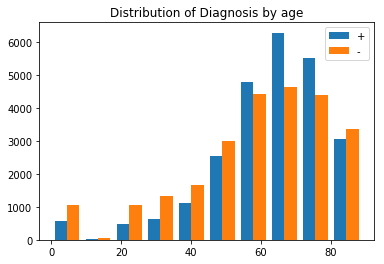

In [108]:
hist_by_diagnosis('age')

# Prediction

## Helpers

In [49]:
def write_solution(solution):
    results = test[['encounter_id','diabetes_mellitus']].set_index('encounter_id')
    results.to_csv('Data/results.csv')

## Diagnosis = 0

In [50]:
solution = pd.read_csv('Data/SolutionTemplateWiDS2021.csv', index_col=0)

In [84]:
test['diabetes_mellitus']=0

In [53]:
write_solution(test)

## Diagnosis = elective_surgery

In [86]:
test['diabetes_mellitus']=test['elective_surgery']

In [55]:
write_solution(test)

## Age logistic regression

In [58]:
training['age'] = training['age'].fillna(0)

In [59]:
has_diabetes = training[training['diabetes_mellitus']==1].sample(25000)
no_diabetes = training[training['diabetes_mellitus']==0].sample(25000)

In [60]:
balanced = pd.concat([has_diabetes,no_diabetes])
balanced

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
7898,262048,118,61.0,24.855351,0,Caucasian,M,180.3,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
65585,152207,50,53.0,33.813358,0,Caucasian,M,173.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
104703,203143,114,72.0,23.809513,0,Asian,F,149.9,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,1,1
21974,196116,161,46.0,38.693878,0,Caucasian,M,175.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
26629,162852,161,67.0,27.091907,0,Caucasian,F,162.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
2085,258804,118,67.0,29.102099,1,African American,M,177.8,Operating Room,Operating Room / Recovery,...,220.0,220.0,0,0,0,0,0,0,0,1
14359,188794,138,62.0,62.784372,0,Caucasian,M,180.3,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
2587,269819,83,60.0,28.688815,0,Caucasian,F,165.1,NaN,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
82045,212097,18,76.0,42.489292,0,Caucasian,F,157.5,Direct Admit,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1
120527,169196,175,52.0,32.000966,0,Caucasian,M,182.0,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,1


In [61]:
training = balanced
clf = lm.LogisticRegression()
clf.fit(training[['age']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf.predict(test[['age']])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [62]:
X_test = np.linspace(0,100,300)

In [63]:
clf.predict(X_test[:,None])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], d

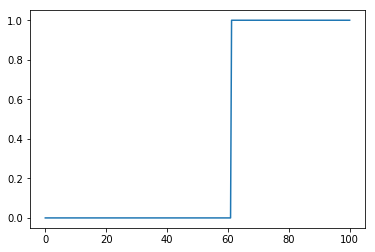

In [64]:
plt.plot(X_test, clf.predict(X_test[:,None]));

In [65]:
write_solution(test)

## Age + BMI logistic regression

In [66]:
balanced['bmi'] = pd.to_numeric(balanced['bmi'])
test['bmi'] = pd.to_numeric(test['bmi'])

In [67]:
balanced['bmi'] = balanced['bmi'].fillna(0)
test['bmi'] = test['bmi'].fillna(0)

In [68]:
clf2 = lm.LogisticRegression()
clf2.fit(training[['age','bmi']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf2.predict(test[['age','bmi']])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
write_solution(test)

## Age + BMI kNN classifier

In [70]:
import sklearn.neighbors as nb

In [71]:
clf3 = nb.KNeighborsClassifier()
clf3.fit(training[['age','bmi']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf3.predict(test[['age','bmi']])

In [72]:
write_solution(test)

## Age, BMI, Glucose Apache kNN

In [73]:
balanced['glucose_apache'] = balanced['glucose_apache'].fillna(0)
test['glucose_apache'] = test['glucose_apache'].fillna(0)

In [74]:
clf3 = nb.KNeighborsClassifier()
clf3.fit(training[['age','bmi','glucose_apache']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf3.predict(test[['age','bmi','glucose_apache']])

In [75]:
write_solution(test)

## Age, BMI, Glucose Apache logistic regression

In [76]:
clf2 = lm.LogisticRegression()
clf2.fit(training[['age','bmi','glucose_apache']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf2.predict(test[['age','bmi','glucose_apache']])

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [77]:
write_solution(test)

## Decision Tree

In [79]:
import sklearn.tree as tree
import sklearn.preprocessing as pp

In [80]:
clf = tree.DecisionTreeClassifier()
clf.fit(training[['age','bmi','glucose_apache']], training['diabetes_mellitus'])
test['diabetes_mellitus']=clf.predict(test[['age','bmi','glucose_apache']])

In [82]:
write_solution(test)

In [ ]:
trainingX = training.drop(columns=['diabetes_mellitus'])
testX = test.drop(columns=['diabetes_mellitus'])

In [ ]:
training['ethnicity'] = training['ethnicity'].fillna("Missing")
test['ethnicity'] = test['ethnicity'].fillna("Missing")

In [ ]:
# TODO: figure out how one-hot encoding works!
enc = pp.OneHotEncoder()
training['ethnicity']=enc.fit_transform(training[['ethnicity']])

In [ ]:
clf.fit(trainingX, training['diabetes_mellitus'])
test['diabetes_mellitus']=clf.predict(testX)